Audio chargé avec succès.
Caractéristiques audio extraites et normalisées.


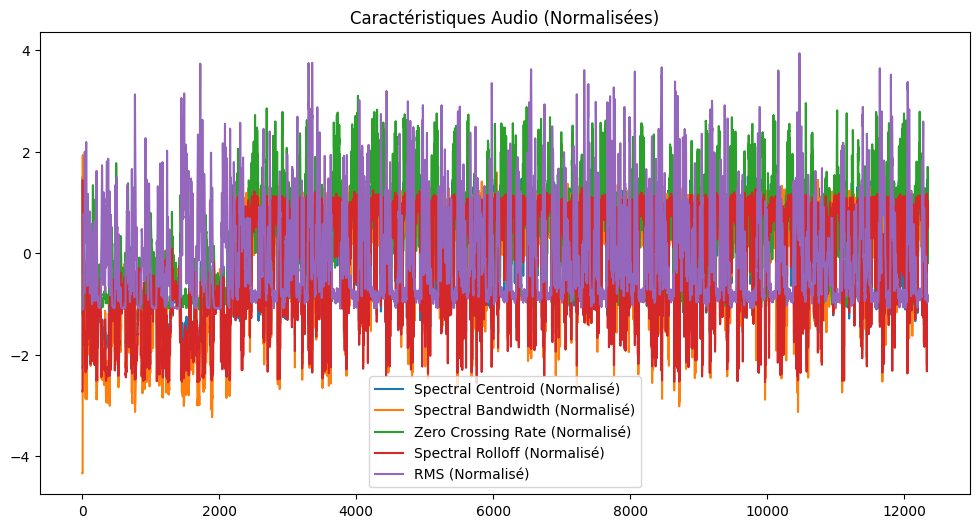

Anomalies détectées aux indices : [    0     1     2     3     4     5     6    45    46    47    48    49
    61    62    63    85    86    87    88    89    90    91    92    93
    94    95    96    97   151   152   153   154   155   156   157   158
   159   160   161   162   184   185   186   187   191   201   202   203
   204   205   206   207   208   209   210   211   212   213   214   215
   216   217   274   275   276   277   278   295   297   298   299   300
   301   302   341   342   343   344   345   346   347   348   349   352
   353   355   356   357   358   359   369   373   374   375   376   377
   378   383   384   385   386   398   399   400   401   427   428   429
   430   475   476   493   494   495   496   497   499   557   558   634
   635   636   642   643   644   666   667   668   669   720   721   722
   723   724   726   727   728   763   764   765   766   767   768   769
   770   771   772   773   774   775   776   777   778   877   878   879
   880   881   88

100%|██████████████████████████████████████████████████████████████████████| 146.25/146.25 [02:40<00:00,  1.10s/seconds]


Réduction de bruit terminée. Fichiers de sortie dans le dossier : demucs_output


In [1]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import subprocess
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

# Récupérer le répertoire courant
CURRENT_DIRECTORY = os.getcwd()

class AudioProcessor:
    def __init__(self, file_path):
        self.file_path = file_path
        self.audio = None
        self.sample_rate = None
        self.features = None
        self.anomaly_indices = []
        self.output_directory = "demucs_output"

    def load_audio(self):
        # Charger l'audio avec Librosa
        self.audio, self.sample_rate = librosa.load(self.file_path, sr=None)
        print("Audio chargé avec succès.")

    def extract_features(self):
        # Calculer les caractéristiques audio
        spectral_centroid = librosa.feature.spectral_centroid(y=self.audio, sr=self.sample_rate)
        spectral_bandwidth = librosa.feature.spectral_bandwidth(y=self.audio, sr=self.sample_rate)
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y=self.audio)
        rolloff = librosa.feature.spectral_rolloff(y=self.audio, sr=self.sample_rate)
        rms = librosa.feature.rms(y=self.audio)
        
        # Combiner toutes les caractéristiques
        self.features = np.column_stack((spectral_centroid[0], spectral_bandwidth[0], 
                                         zero_crossing_rate[0], rolloff[0], rms[0]))
        
        # Normaliser les caractéristiques
        scaler = StandardScaler()
        self.features = scaler.fit_transform(self.features)
        print("Caractéristiques audio extraites et normalisées.")

    def visualize_features(self):
        # Visualiser les caractéristiques audio normalisées
        plt.figure(figsize=(12, 6))
        plt.plot(self.features[:, 0], label='Spectral Centroid (Normalisé)')
        plt.plot(self.features[:, 1], label='Spectral Bandwidth (Normalisé)')
        plt.plot(self.features[:, 2], label='Zero Crossing Rate (Normalisé)')
        plt.plot(self.features[:, 3], label='Spectral Rolloff (Normalisé)')
        plt.plot(self.features[:, 4], label='RMS (Normalisé)')
        plt.legend()
        plt.title("Caractéristiques Audio (Normalisées)")
        plt.show()

    def detect_anomalies(self):
        # Détecter les anomalies avec Isolation Forest
        model = IsolationForest(n_estimators=100, contamination=0.05)
        model.fit(self.features)
        anomalies = model.predict(self.features)
        self.anomaly_indices = np.where(anomalies == -1)[0]  # Indices des anomalies
        anomaly_detected = len(self.anomaly_indices) > 0
        if anomaly_detected:
            print(f"Anomalies détectées aux indices : {self.anomaly_indices}")
        else:
            print("Aucune anomalie détectée.")
        return anomaly_detected

    def reduce_noise_with_demucs(self):
        # Exécuter Demucs pour réduire le bruit
        print("Réduction de bruit avec Demucs en cours...")
        try:
            # Créer le dossier de sortie s'il n'existe pas déjà
            if not os.path.exists(self.output_directory):
                os.makedirs(self.output_directory)

            # Exécuter Demucs avec le chemin de fichier et spécifier le dossier de sortie
            subprocess.run(["demucs", self.file_path, "-o", self.output_directory], check=True)
            print(f"Réduction de bruit terminée. Fichiers de sortie dans le dossier : {self.output_directory}")
        except subprocess.CalledProcessError as e:
            print(f"Erreur lors de l'exécution de Demucs : {e}")

    def process_audio(self):
        # Charger, traiter et analyser l'audio
        self.load_audio()
        self.extract_features()
        self.visualize_features()
        if self.detect_anomalies():
            self.reduce_noise_with_demucs()
        else:
            print("Aucune réduction de bruit nécessaire, mais Demucs peut être utilisé pour améliorer l'audio.")

# Exécution principale
if __name__ == "__main__":
    file_path = f"{CURRENT_DIRECTORY}/data/radiobruite.wav"

    processor = AudioProcessor(file_path)
    processor.process_audio()
